In [1]:
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.compare import *
from pymodulon.io import load_json_model
from pymodulon.plotting import *
from pymodulon.example_data import load_bsub_data, load_ecoli_data
from sklearn.metrics.pairwise import cosine_similarity

# Comparison of iModulons across species
Try to make some sort of network analysis comparing iMs across multiple species.

In [2]:
from Bio import SeqIO

def parse_gbff(file_path):
    protein_to_locus = {}
    for record in SeqIO.parse(file_path, 'genbank'):
        for feature in record.features:
            if feature.type == 'CDS':
                protein_id = feature.qualifiers.get('protein_id', [''])[0]
                locus_tag = feature.qualifiers.get('locus_tag', [''])[0]
                protein_to_locus[protein_id] = locus_tag
    return protein_to_locus

# Parse the gbff files and extract protein IDs and locus tags for each species
salb_protein_to_locus = parse_gbff('../../data/external/genomes/Sal.gbff')
ecol_protein_to_locus = parse_gbff('../../data/external/genomes/Eco.gbff')
mtub_protein_to_locus = parse_gbff('../../data/external/genomes/Mtu.gbff')
pae_protein_to_locus = parse_gbff('../../data/external/genomes/Pae.gbff')
sen_protein_to_locus = parse_gbff('../../data/external/genomes/Sen.gbff')
sac_protein_to_locus = parse_gbff('../../data/external/genomes/sac.gbff')


In [3]:
# Define orthologous genes based on orthofinder results, by parsing the N0.tsv file in Phylogenetic_Hierarchical_Orthogroups
orthogroups = pd.read_csv('../../data/external/orthofinder/Orthogroups/Orthogroups.tsv', sep='\t')

orthogroups

,Orthogroup,Eco,Mtu,Pae,Sal,Sen,sac
0,OG0000000,NaN,"NP_214664.1, YP_177692.1, YP_177693.1, YP_1776...",NaN,NaN,NaN,NaN
1,OG0000001,"NP_415611.1, NP_416136.1, NP_416641.1, NP_4169...","NP_215201.1, NP_215283.1, NP_215442.1, NP_2155...","NP_250161.1, NP_250340.1, NP_250518.1, NP_2505...","WP_003946506.1, WP_003946586.1, WP_003946893.1...","NP_460165.1, NP_461116.1, NP_461380.1, NP_4619...","WP_011277119.1, WP_011277156.1, WP_011277956.1..."
2,OG0000002,NaN,"YP_177655.1, YP_177677.1, YP_177690.1, YP_1777...",NaN,NaN,NaN,NaN
3,OG0000003,NaN,"NP_215456.1, YP_177802.1",NP_251476.1,"WP_003946668.1, WP_003946743.1, WP_003946797.1...",NaN,NaN
4,OG0000004,"NP_414846.1, NP_415816.1, NP_415903.4, NP_4159...","NP_214737.1, NP_214748.2, NP_214972.1, NP_2152...","NP_248910.1, NP_248956.1, NP_250674.1, NP_2508...","WP_003948365.1, WP_003948551.1, WP_003948955.1...","NP_460075.1, NP_460556.3, NP_461717.1, NP_4620...","WP_011277087.1, WP_011277147.1, WP_011277953.1..."
...,...,...,...,...,...,...,...
5057,OG0005057,NaN,NaN,NaN,NaN,NaN,"WP_011279137.1, WP_011279139.1"
5058,OG0005058,NaN,NaN,NaN,NaN,NaN,"WP_015385485.1, WP_230937967.1"
5059,OG0005059,NaN,NaN,NaN,NaN,NaN,"WP_015385608.1, WP_024084720.1"
5060,OG0005060,NaN,NaN,NaN,NaN,NaN,"WP_015385767.1, WP_015385768.1"


In [11]:
# Split the genes in each cell
orthogroups['Eco'] = orthogroups['Eco'].str.split(', ')
orthogroups['Mtu'] = orthogroups['Mtu'].str.split(', ')
orthogroups['Pae'] = orthogroups['Pae'].str.split(', ')
orthogroups['Sal'] = orthogroups['Sal'].str.split(', ')
orthogroups['Sen'] = orthogroups['Sen'].str.split(', ')
orthogroups['sac'] = orthogroups['sac'].str.split(', ')

# Put each gene on a separate row
orthogroups = orthogroups.explode('Eco')
orthogroups = orthogroups.explode('Mtu')
orthogroups = orthogroups.explode('Pae')
orthogroups = orthogroups.explode('Sal')
orthogroups = orthogroups.explode('Sen')
orthogroups = orthogroups.explode('sac')

orthogroups

,Orthogroup,Eco,Mtu,Pae,Sal,Sen,sac
0,OG0000000,NaN,NP_214664.1,NaN,NaN,NaN,NaN
0,OG0000000,NaN,YP_177692.1,NaN,NaN,NaN,NaN
0,OG0000000,NaN,YP_177693.1,NaN,NaN,NaN,NaN
0,OG0000000,NaN,YP_177695.1,NaN,NaN,NaN,NaN
0,OG0000000,NaN,YP_177696.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5059,OG0005059,NaN,NaN,NaN,NaN,NaN,WP_024084720.1
5060,OG0005060,NaN,NaN,NaN,NaN,NaN,WP_015385767.1
5060,OG0005060,NaN,NaN,NaN,NaN,NaN,WP_015385768.1
5061,OG0005061,NaN,NaN,NaN,NaN,NaN,WP_230937877.1


In [12]:
# Replace the protein IDs with locus tags
orthogroups['Eco'] = orthogroups['Eco'].replace(ecol_protein_to_locus)

In [13]:
orthogroups['Mtu'] = orthogroups['Mtu'].replace(mtub_protein_to_locus)

In [14]:
orthogroups['Pae'] = orthogroups['Pae'].replace(pae_protein_to_locus)

In [15]:
orthogroups['Sal'] = orthogroups['Sal'].replace(salb_protein_to_locus)

In [16]:
orthogroups['Sen'] = orthogroups['Sen'].replace(sen_protein_to_locus)

In [17]:
orthogroups['sac'] = orthogroups['sac'].replace(sac_protein_to_locus)

orthogroups


,Orthogroup,Eco,Mtu,Pae,Sal,Sen,sac
0,OG0000000,NaN,Rv0150c,NaN,NaN,NaN,NaN
0,OG0000000,NaN,Rv0109,NaN,NaN,NaN,NaN
0,OG0000000,NaN,Rv0124,NaN,NaN,NaN,NaN
0,OG0000000,NaN,Rv0151c,NaN,NaN,NaN,NaN
0,OG0000000,NaN,Rv0152c,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5059,OG0005059,NaN,NaN,NaN,NaN,NaN,SACI_RS11170
5060,OG0005060,NaN,NaN,NaN,NaN,NaN,SACI_RS10100
5060,OG0005060,NaN,NaN,NaN,NaN,NaN,SACI_RS10105
5061,OG0005061,NaN,NaN,NaN,NaN,NaN,SACI_RS02475


In [18]:
orthogroups.to_csv('../../data/external/orthofinder/Orthogroups/orthogroups_locus.tsv', sep='\t', index=False)  

In [4]:
orthogroups = pd.read_csv('../../data/external/orthofinder/Orthogroups/orthogroups_locus.tsv', sep='\t')

In [10]:
# Define a dictionary with the orthologous genes for each species
orthologous_genes = {}
for index, row in orthogroups.iterrows():
    gene_list = row[['Eco', 'Mtu', 'Pae', 'Sal', 'Sen', 'sac']].tolist()
    if row['Orthogroup'] not in orthologous_genes:
        orthologous_genes[row['Orthogroup']] = set(gene_list)
    else:
        orthologous_genes[row['Orthogroup']].update(gene_list)

# Convert the sets back to lists
for key in orthologous_genes:
    orthologous_genes[key] = list(orthologous_genes[key])

In [11]:
# Create function to calculate cosine similarity between two iModulons, ignoring Nan values
def cosine_similarity_ignore_nan(v1, v2):
    mask = ~np.isnan(v1) & ~np.isnan(v2)
    if not mask.any():
        return np.nan
    v1 = v1[mask]
    v2 = v2[mask]
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [11]:
# Load the M files
ecol_M = pd.read_csv("../../data/external/M_files/ecol_M.csv", index_col=0)
mtub_M = pd.read_csv("../../data/external/M_files/mtub_M.csv", index_col=0)
pae_M = pd.read_csv("../../data/external/M_files/pae_M.csv", index_col=0)
sac_M = pd.read_csv("../../data/external/M_files/sac_M.csv", index_col=0)
sen_M = pd.read_csv("../../data/external/M_files/sen_M.csv", index_col=0)
salb_ica = load_json_model("../../data/processed/salb.json.gz")
salb_M = salb_ica.M
salb_M.columns = [col.replace(', ', '-') if ', ' in col else col for col in salb_M.columns]

# Create a mapping from gene IDs to orthogroups
orthogroup_mapping = {gene: orthogroup for orthogroup, genes in orthologous_genes.items() for gene in genes}

# Modify the mapping to keep the locus_tag if the gene is not associated with an orthogroup
for gene in salb_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene

for gene in mtub_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene

for gene in ecol_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene

for gene in pae_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene

for gene in sac_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene

for gene in sen_M.index:
    if gene not in orthogroup_mapping:
        orthogroup_mapping[gene] = gene


salb_M.index = salb_M.index.map(orthogroup_mapping)
mtub_M.index = mtub_M.index.map(orthogroup_mapping)
ecol_M.index = ecol_M.index.map(orthogroup_mapping)
pae_M.index = pae_M.index.map(orthogroup_mapping)
sac_M.index = sac_M.index.map(orthogroup_mapping)
sen_M.index = sen_M.index.map(orthogroup_mapping)

# Remove rows with NaN in the index
salb_M = salb_M[salb_M.index.notna()]
mtub_M = mtub_M[mtub_M.index.notna()]
ecol_M = ecol_M[ecol_M.index.notna()]
pae_M = pae_M[pae_M.index.notna()]
sac_M = sac_M[sac_M.index.notna()]
sen_M = sen_M[sen_M.index.notna()]

# If there is more than one row with the same index, take the max for each column
salb_M = salb_M.groupby(salb_M.index).max()
mtub_M = mtub_M.groupby(mtub_M.index).max()
ecol_M = ecol_M.groupby(ecol_M.index).max()
pae_M = pae_M.groupby(pae_M.index).max()
sac_M = sac_M.groupby(sac_M.index).max()
sen_M = sen_M.groupby(sen_M.index).max()

# Add prefix to column names
salb_M = salb_M.add_prefix('salb_')
mtub_M = mtub_M.add_prefix('mtub_')
ecol_M = ecol_M.add_prefix('ecol_')
pae_M = pae_M.add_prefix('pae_')
sac_M = sac_M.add_prefix('sac_')
sen_M = sen_M.add_prefix('sen_')

# Merge the M files on the index
M = pd.concat([salb_M, mtub_M, ecol_M, pae_M, sen_M, sac_M], axis=1, join='outer')
M

# Create a dataframe for the edges
edges = []
for i in range(M.shape[1]):
    for j in range(i+1, M.shape[1]):
        sim = cosine_similarity_ignore_nan(M.iloc[:, i], M.iloc[:, j])
        edges.append([M.columns[i], M.columns[j], sim])

edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])

# Export the edges to a CSV file
edges_df.to_csv('../../data/processed/network.csv', index=False)
edges_df

,Source,Target,Weight
0,salb_Fatty Acid,salb_Nucleoside,0.120118
1,salb_Fatty Acid,salb_Cytochrome,0.111867
2,salb_Fatty Acid,salb_Transketolase,0.103684
3,salb_Fatty Acid,salb_Cyclofaulknamycin-2,0.085187
4,salb_Fatty Acid,salb_Candicidin/Antimycin,0.138346
...,...,...,...
191885,sac_Thiamin,sac_single_gene_5,0.046934
191886,sac_Thiamin,sac_Gly-Ser-Thr,-0.009575
191887,sac_unchar-3,sac_single_gene_5,0.029222
191888,sac_unchar-3,sac_Gly-Ser-Thr,0.041643


In [34]:
salb_M

,salb_Fatty Acid,salb_Nucleoside,salb_Cytochrome,salb_Transketolase,salb_Cyclofaulknamycin-2,salb_Candicidin/Antimycin,salb_Thiopeptide,salb_Ammonium,salb_Mce3R,salb_UC-1,...,salb_Potassium,salb_Sucrose,salb_UC-11,salb_UC-12,salb_NDH,salb_UC-13,salb_SAL-2242,salb_UC-14,salb_Sugar-2,salb_hrt Complex
OG0000001,0.081877,0.062016,0.042228,0.152147,0.041185,0.155574,0.037621,0.048256,0.046342,0.018017,...,0.033027,0.015594,0.015604,0.026340,0.023491,0.008340,0.044375,0.037564,0.034858,0.037662
OG0000003,0.020055,0.041521,0.021890,0.019497,0.018901,0.045777,0.030457,0.015914,0.022982,0.030264,...,0.037386,0.031419,0.055692,0.039851,0.046739,0.021594,0.026310,0.027376,0.036576,0.025661
OG0000004,0.063467,0.065647,0.010763,0.007152,0.010662,0.007943,0.022232,0.044397,0.016106,0.004587,...,0.025634,0.014754,0.020463,0.012782,0.029397,-0.000493,0.007276,0.005862,0.012856,0.025669
OG0000005,0.100539,0.020258,0.019982,0.016263,0.022748,0.013165,0.038696,0.013614,0.017234,0.029226,...,0.023912,0.018875,0.013611,0.018086,0.021583,0.008088,0.010906,0.008911,0.010476,0.007776
OG0000006,0.002839,0.022338,0.080695,0.018836,0.011635,0.009274,0.009411,0.015180,0.032883,0.015389,...,0.016576,0.012120,0.015928,0.010163,0.010274,0.005968,0.017052,0.038714,0.037170,0.014822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XNR_RS31650,-0.020359,-0.034599,0.029638,-0.013307,-0.015305,0.002279,0.011569,-0.018373,0.046591,-0.013620,...,-0.019278,-0.003794,0.004034,0.023918,-0.001918,0.009151,0.003092,0.074419,-0.001265,0.002975
XNR_RS31655,-0.010727,0.019932,-0.001763,0.001117,-0.013124,0.003766,0.011213,0.011110,0.000847,-0.003478,...,-0.027313,-0.048687,0.031408,0.012113,-0.015799,0.008811,-0.025422,0.006535,-0.028007,0.021224
XNR_RS31660,0.002039,0.003674,-0.009002,0.016249,0.010439,-0.012869,0.005386,0.013400,-0.008761,-0.005185,...,-0.017133,0.012276,0.008204,0.028713,-0.013402,-0.011430,-0.024600,0.030980,-0.016412,0.014330
XNR_RS31665,0.015349,-0.011338,-0.003713,0.016108,-0.003046,-0.001631,-0.005394,0.010781,0.049902,0.025709,...,-0.021335,-0.025332,0.005389,-0.009275,0.022604,0.011884,0.001372,-0.033777,-0.022141,0.057445


In [35]:
M.to_csv('../../data/processed/merged_M_max.csv')

# Change the names of the orthogroups ids to identifiable gene names

In [5]:
M = pd.read_csv('../../data/processed/merged_M_max.csv', index_col=0)

In [5]:
from Bio import SeqIO

def parse_gbff(file_path):
    locus_to_gene = {}  # New dictionary to store locus tag to gene name mapping
    protein_to_locus = {}
    for record in SeqIO.parse(file_path, 'genbank'):
        for feature in record.features:
            if feature.type == 'CDS':
                protein_id = feature.qualifiers.get('protein_id', [''])[0]
                locus_tag = feature.qualifiers.get('locus_tag', [''])[0]
                gene_name = feature.qualifiers.get('gene', [''])[0]  # Extract the gene name
                protein_to_locus[protein_id] = locus_tag
                locus_to_gene[locus_tag] = gene_name  # Store the gene name in the dictionary
    return protein_to_locus, locus_to_gene

# Parse the gbff files and extract protein IDs, locus tags, and gene names for each species
salb_protein_to_locus, salb_locus_to_gene = parse_gbff('../../data/external/genomes/Sal.gbff')
ecol_protein_to_locus, ecol_locus_to_gene = parse_gbff('../../data/external/genomes/Eco.gbff')
mtub_protein_to_locus, mtub_locus_to_gene = parse_gbff('../../data/external/genomes/Mtu.gbff')
pae_protein_to_locus, pae_locus_to_gene = parse_gbff('../../data/external/genomes/Pae.gbff')
sen_protein_to_locus, sen_locus_to_gene = parse_gbff('../../data/external/genomes/Sen.gbff')
sac_protein_to_locus, sac_locus_to_gene = parse_gbff('../../data/external/genomes/sac.gbff')


In [33]:
# Create a new dictionary to store the mapping from orthogroups to gene names
orthogroup_to_gene = {}

# List of protein_to_gene dictionaries in the order you want to check them
protein_to_gene_dicts = [ecol_locus_to_gene, salb_locus_to_gene, mtub_locus_to_gene, pae_locus_to_gene, sen_locus_to_gene, sac_locus_to_gene]

class BreakIt(Exception): pass

# For each orthogroup in the orthologous_genes dictionary
for orthogroup, locus_tags in orthologous_genes.items():
    try:
        # For each locus tag
        for locus_tag in locus_tags:
            # Check the ecol_locus_to_gene dictionary first
            if locus_tag in ecol_locus_to_gene:
                # Add the gene name to the orthogroup_to_gene dictionary and break the loop
                orthogroup_to_gene[orthogroup] = ecol_locus_to_gene[locus_tag]
                raise BreakIt
            # For each of the other protein_to_gene dictionaries
            for protein_to_gene in protein_to_gene_dicts[1:]:
                # If the locus tag is in the dictionary
                if locus_tag in protein_to_gene:
                    # Add the gene name to the orthogroup_to_gene dictionary
                    orthogroup_to_gene[orthogroup] = protein_to_gene[locus_tag]
            # If the locus tag is not in any dictionary, add the locus tag itself to the orthogroup_to_gene dictionary
            else:
                orthogroup_to_gene[orthogroup] = locus_tag
    except BreakIt:
        continue

In [34]:
orthogroup_to_gene

{'OG0000000': 'Rv1468c',
 'OG0000001': 'ucpA',
 'OG0000002': 'Rv2768c',
 'OG0000003': 'XNR_RS24240',
 'OG0000004': 'feaB',
 'OG0000005': 'caiA',
 'OG0000006': 'malI',
 'OG0000007': 'nikD',
 'OG0000008': 'menB',
 'OG0000009': 'acrR',
 'OG0000010': 'cysA',
 'OG0000011': 'XNR_RS13725',
 'OG0000012': 'narP',
 'OG0000013': 'lrp',
 'OG0000014': 'rcdB',
 'OG0000015': 'pdeR',
 'OG0000016': 'fadK',
 'OG0000017': 'hxpA',
 'OG0000018': 'yadG',
 'OG0000019': 'pspF',
 'OG0000020': 'wcaL',
 'OG0000021': 'PA0180',
 'OG0000022': 'XNR_RS16400',
 'OG0000023': 'yjhI',
 'OG0000024': 'dosC',
 'OG0000025': 'cspD',
 'OG0000026': 'XNR_RS15975',
 'OG0000027': 'dkgA',
 'OG0000028': 'cpxR',
 'OG0000029': 'deaD',
 'OG0000030': 'ycjP',
 'OG0000031': 'rspR',
 'OG0000032': 'entF',
 'OG0000033': 'proP',
 'OG0000034': 'XNR_RS20545',
 'OG0000035': 'gltL',
 'OG0000036': 'ugpA',
 'OG0000037': 'mmuP',
 'OG0000038': 'copA',
 'OG0000039': 'Rv2934',
 'OG0000040': 'XNR_RS14350',
 'OG0000041': 'yfdE',
 'OG0000042': 'dppC',
 'O

In [35]:
# Replace the index of the M DataFrame with the gene names from the orthogroup_to_gene dictionary
# If the orthogroup does not have a gene name or the gene name is an empty string, keep the orthogroup id as it was
M.index = M.index.map(lambda x: orthogroup_to_gene.get(x, x) if orthogroup_to_gene.get(x, x) != '' else x)

In [36]:
M

,salb_Fatty Acid,salb_Nucleoside,salb_Cytochrome,salb_Transketolase,salb_Cyclofaulknamycin-2,salb_Candicidin/Antimycin,salb_Thiopeptide,salb_Ammonium,salb_Mce3R,salb_UC-1,...,sac_translation-related,sac_Quinolinate,sac_aromatic-degradation,sac_Ammonium-Uptake,sac_carotenoid,sac_single_gene_4,sac_Thiamin,sac_unchar-3,sac_single_gene_5,sac_Gly-Ser-Thr
fabG,0.081877,0.062016,0.042228,0.152147,0.041185,0.155574,0.037621,0.048256,0.046342,0.018017,...,0.013529,0.020704,0.015626,0.005800,0.019158,0.014035,0.007950,0.025101,0.019810,0.011202
XNR_RS24240,0.020055,0.041521,0.021890,0.019497,0.018901,0.045777,0.030457,0.015914,0.022982,0.030264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exaC,0.063467,0.065647,0.010763,0.007152,0.010662,0.007943,0.022232,0.044397,0.016106,0.004587,...,0.018378,0.008318,0.012854,0.033214,0.035137,0.007509,0.013877,0.027024,0.030449,0.024564
caiA,0.100539,0.020258,0.019982,0.016263,0.022748,0.013165,0.038696,0.013614,0.017234,0.029226,...,0.005109,0.041070,0.024294,0.034491,0.022676,0.026023,0.006924,0.029883,0.013032,0.023139
malI,0.002839,0.022338,0.080695,0.018836,0.011635,0.009274,0.009411,0.015180,0.032883,0.015389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006145,0.006680,0.033234,0.012526,-0.011236,-0.037753,-0.006739,-0.042655,-0.009526,0.024212
SACI_RS11990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.004003,0.040329,-0.100403,-0.019895,0.008920,0.508807,-0.017098,-0.002504,-0.090708,0.031241
SACI_RS11995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035465,-0.011955,-0.011443,0.008638,-0.017436,-0.008210,-0.001651,-0.006301,-0.006739,-0.061700
SACI_RS12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.040270,0.028730,0.015424,-0.021659,-0.006746,0.035470,0.029327,-0.022018,-0.042210,0.019741


# Create node table

In [26]:
# create node tables listing all iModulons and the species
salb_M_T = salb_M.T
salb_nodes = pd.DataFrame(index=salb_M_T.index)
salb_nodes['species'] = 'Sal'

mtub_M_T = mtub_M.T
mtub_nodes = pd.DataFrame(index=mtub_M_T.index)
mtub_nodes['species'] = 'Mtu'

ecol_M_T = ecol_M.T
ecol_nodes = pd.DataFrame(index=ecol_M_T.index)
ecol_nodes['species'] = 'Eco'

pae_M_T = pae_M.T
pae_nodes = pd.DataFrame(index=pae_M_T.index)
pae_nodes['species'] = 'Pae'

sen_M_T = sen_M.T
sen_nodes = pd.DataFrame(index=sen_M_T.index)
sen_nodes['species'] = 'Sen'

sac_M_T = sac_M.T
sac_nodes = pd.DataFrame(index=sac_M_T.index)
sac_nodes['species'] = 'sac'

# Concatenate the node tables
nodes = pd.concat([salb_nodes, mtub_nodes, ecol_nodes, pae_nodes, sen_nodes, sac_nodes])
nodes

,species
salb_Fatty Acid,Sal
salb_Nucleoside,Sal
salb_Cytochrome,Sal
salb_Transketolase,Sal
salb_Cyclofaulknamycin-2,Sal
...,...
sac_single_gene_4,sac
sac_Thiamin,sac
sac_unchar-3,sac
sac_single_gene_5,sac


In [27]:
nodes

,species
salb_Fatty Acid,Sal
salb_Nucleoside,Sal
salb_Cytochrome,Sal
salb_Transketolase,Sal
salb_Cyclofaulknamycin-2,Sal
...,...
sac_single_gene_4,sac
sac_Thiamin,sac
sac_unchar-3,sac
sac_single_gene_5,sac


In [28]:
nodes.to_csv('../../data/processed/nodes.csv')

# Load all ICA objects to allow for comparison

In [2]:
data_dir = path.join('../../','data','external', 'modulome', 'ica_objects')

ecol_ica = load_json_model(data_dir + '/precise1k.json')
mtub_ica = load_json_model(data_dir + '/mtb_ica.json')
pae_ica = load_json_model(data_dir + '/paeru_116_iModulon.json')
sen_ica = load_json_model(data_dir + '/core.json')
sac_ica = load_json_model(data_dir + '/saci_ica_data.json')
salb_ica = load_json_model("../../data/processed/salb.json.gz")

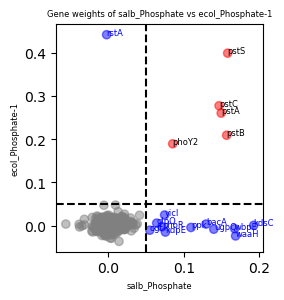

In [68]:
# Convert the page size from mm to inches
width = 75 / 25.4  # ~6.69 inches
height = 75 / 25.4  # ~7.87 inches

# Assume 'imodulon1' and 'imodulon2' are the names of the iModulons
imodulon1 = 'salb_Phosphate'
imodulon2 = 'ecol_Phosphate-1'

# Extract the weights for the two iModulons
weights1 = M[imodulon1]
weights2 = M[imodulon2]

# Remove non-finite values
finite_indices = np.isfinite(weights1) & np.isfinite(weights2)
weights1 = weights1[finite_indices]
weights2 = weights2[finite_indices]

# Create the scatter plot
plt.figure(figsize=(width, height))

# Define the threshold
threshold = 0.05

# Add lines at the threshold level
plt.axhline(y=threshold, color='k', linestyle='--')
plt.axvline(x=threshold, color='k', linestyle='--')

# Color the dots based on the threshold
colors = np.where((weights1 > threshold) & (weights2 > threshold), 'red', 
          np.where((weights1 > threshold) | (weights2 > threshold), 'blue', 'grey'))
plt.scatter(weights1, weights2, color=colors, alpha=0.5)

# Define top_n
top_n = 12 

# Identify the points with the highest weights that are above both thresholds
highest_weights = weights1[(weights1 > threshold) & (weights2 > threshold)].nlargest(top_n)

for label in highest_weights.index:
    x = weights1.loc[label].mean()
    y = weights2.loc[label].mean()
    plt.text(x, y, label, fontsize=6)

# Identify the points with the highest weights that are above either threshold
highest_weights_blue = weights1[((weights1 > threshold) | (weights2 > threshold)) & ~((weights1 > threshold) & (weights2 > threshold))].nlargest(top_n)

for label in highest_weights_blue.index:
    x = weights1.loc[label].mean()
    y = weights2.loc[label].mean()
    plt.text(x, y, label, fontsize=6, color='blue')

plt.xlabel(imodulon1, fontsize=6)
plt.ylabel(imodulon2, fontsize=6)
plt.title('Gene weights of ' + imodulon1 + ' vs ' + imodulon2, fontsize=6)

# Adjust the margins
plt.subplots_adjust(left=0.20)

plt.savefig('../../figures/panel2/phosphate_plot.svg')
plt.show()

In [65]:
for i in highest_weights.index:
    print(f'Coordinates: {weights1.loc[i]}, {weights2.loc[i]}')
    print(f'Label: {i}')

Coordinates: 0.1583352390646874, 0.3990584127813249
Label: pstS2
Coordinates: 0.1570206759785566, 0.2091507041698833
Label: phoT
Coordinates: 0.1497327523502142, 0.2603572911193988
Label: pstA
Coordinates: 0.1469366167752905, 0.2773588957661102
Label: pstC
Coordinates: 0.0853794618844173, 0.1893045993360937
Label: phoU


## Load cluster info from cytoscape

In [6]:
clusters = pd.read_csv('../../data/processed/network_table.csv')

In [7]:
clusters

,__mclCluster,AverageShortestPathLength,BetweennessCentrality,ClosenessCentrality,ClusteringCoefficient,Degree,degree.layout,Eccentricity,Function,IsSingleNode,...,NumDescendents,PartnerOfMultiEdgedNodePairs,Radiality,selected,SelfLoops,shared name,species,Stress,TopologicalCoefficient,label
0,84.0,4.363139,0.000886,0.229193,0.000000,2,2,8,Envelope Stress,False,...,NaN,0,0.954552,False,0,ecol_glrR KO,Eco,1128,0.500000,glrR KO
1,6.0,5.036496,0.011064,0.198551,0.166667,4,4,9,Antibiotic Resistance,False,...,NaN,0,0.945453,False,0,pae_MexS-2,Pae,20016,0.359375,MexS-2
2,27.0,4.069343,0.020664,0.245740,0.066667,6,6,8,Other Functional,False,...,NaN,0,0.958522,False,0,sac_carotenoid,sac,23526,0.181159,carotenoid
3,2.0,3.056569,0.031303,0.327164,0.147692,26,26,6,Fatty Acid Metabolism,False,...,NaN,0,0.972209,False,0,salb_Fatty Acid,Sal,53336,0.083112,Fatty Acid
4,8.0,4.361314,0.002007,0.229289,0.488889,10,10,8,Metal Homeostasis,False,...,NaN,0,0.954577,False,0,pae_CysB-2,Pae,3696,0.283871,CysB-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,1.0,3.583942,0.001847,0.279022,0.000000,2,2,7,Carbon Metabolism,False,...,NaN,0,0.965082,False,0,ecol_Rhamnose,Eco,3402,0.505952,Rhamnose
560,26.0,4.122263,0.000000,0.242585,1.000000,3,3,7,Metal Homeostasis,False,...,NaN,0,0.957807,False,0,sen_kdpE,Sen,0,0.470588,kdpE
561,126.0,5.193431,0.000000,0.192551,1.000000,2,2,8,Carbon Metabolism,False,...,NaN,0,0.943332,False,0,sen_rcsc related,Sen,0,0.625000,rcsc related
562,73.0,4.204380,0.002296,0.237847,0.333333,3,3,8,Amino Acid Metabolism,False,...,NaN,0,0.956698,False,0,mtub_LysG,Mtu,2868,0.375000,LysG


Putative core genes in cluster 5: 9 (['entF', 'ybdB', 'ybdZ', 'entB', 'entA', 'entC', 'entE', 'pfeA', 'fpvB'])


<Figure size 393.701x472.441 with 0 Axes>

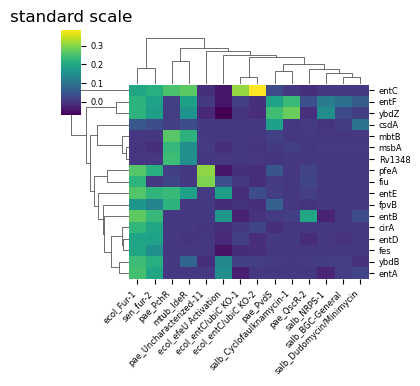

In [46]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 5

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.25)

# Set gene weight threshold
threshold = 0.1

# Filter if at least two iModulons have a weight above the threshold
filtered_weights = weights[(weights > threshold).sum(axis=1) > 1]

# Count the number of iModulons where each gene's weight is above the threshold
counts = (weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 100 / 25.4  # ~6.69 inches
height = 120 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height))  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('../../figures/panel4/heatmap.svg', format='svg', dpi=300)
plt.show()

# Panel 5: Uncharacterized iModulons

Putative core genes in cluster 12: 20 (['entS', 'aztA', 'fepG', 'fepD', 'nfeF', 'bfd', 'foxI', 'vreR', 'foxA', 'tolR', 'fes', 'fepB', 'tonB', 'feoA', 'feoB', 'yhgG', 'fhuC', 'ydiE', 'exbB', 'fhuF'])


<Figure size 393.701x472.441 with 0 Axes>

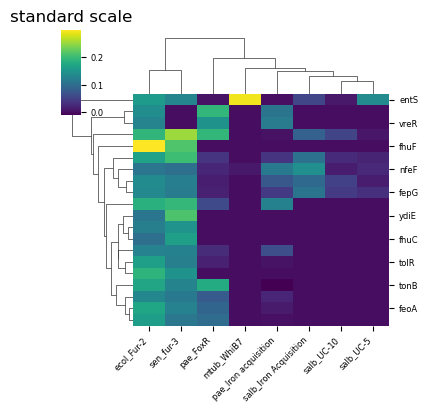

In [55]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 12

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.25)

# Set gene weight threshold
threshold = 0.1

# Filter if at least two iModulons have a weight above the threshold
filtered_weights = weights[(weights > threshold).sum(axis=1) > 1]

# Count the number of iModulons where each gene's weight is above the threshold
counts = (weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 100 / 25.4  # ~6.69 inches
height = 120 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height))  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('../../figures/panel5/UC-5_10heatmap.svg', format='svg', dpi=300)
plt.show()

Putative core genes in cluster 12: 20 (['entS', 'aztA', 'fepG', 'fepD', 'nfeF', 'bfd', 'foxI', 'vreR', 'foxA', 'tolR', 'fes', 'fepB', 'tonB', 'feoA', 'feoB', 'yhgG', 'fhuC', 'ydiE', 'exbB', 'fhuF'])


<Figure size 393.701x551.181 with 0 Axes>

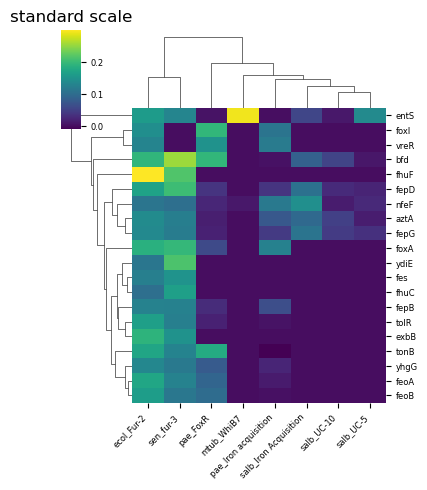

In [54]:
import seaborn as sns

# Assume 'clusters' is your DataFrame and 'cluster_id' is the id of the cluster you're interested in
cluster_id = 12

# Filter the DataFrame based on the cluster id
cluster = clusters[clusters['__mclCluster'] == cluster_id]

# Get the list of iModulons
iModulons = cluster['name'].tolist()

# Extract the weights for the iModulons
weights = M[iModulons]

# Fill Na values with 0
weights = weights.fillna(0)

# Set the threshold to be at least 50% of the iModulons
iModulon_threshold = int(len(iModulons) * 0.25)

# Set gene weight threshold
threshold = 0.1

# Filter if at least two iModulons have a weight above the threshold
filtered_weights = weights[(weights > threshold).sum(axis=1) > 1]

# Count the number of iModulons where each gene's weight is above the threshold
counts = (weights >= threshold).sum(axis=1)

# Get the genes that are "core" to the cluster
core_genes = counts[counts >= iModulon_threshold].index.tolist()

print(f'Putative core genes in cluster {cluster_id}: {len(core_genes)} ({core_genes})')

# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 100 / 25.4  # ~6.69 inches
height = 140 / 25.4  # ~3.94 inches

# Create the clustered heatmap with increased height
plt.figure(figsize=(width, height))  # Adjust the height as needed
g = sns.clustermap(filtered_weights, cmap='viridis', figsize=(width, height))  # Adjust the height as needed

# Rotate the x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6, rotation=45, ha='right')

# Set the size of the colorbar labels
cbar = g.cax
cbar.yaxis.set_tick_params(labelsize=6)  # Adjust the size as needed

# Set the size of the row labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # Adjust the size as needed

plt.title('standard scale')

# save as svg
plt.savefig('../../figures/panel5/UC-3heatmap.svg', format='svg', dpi=300)
plt.show()

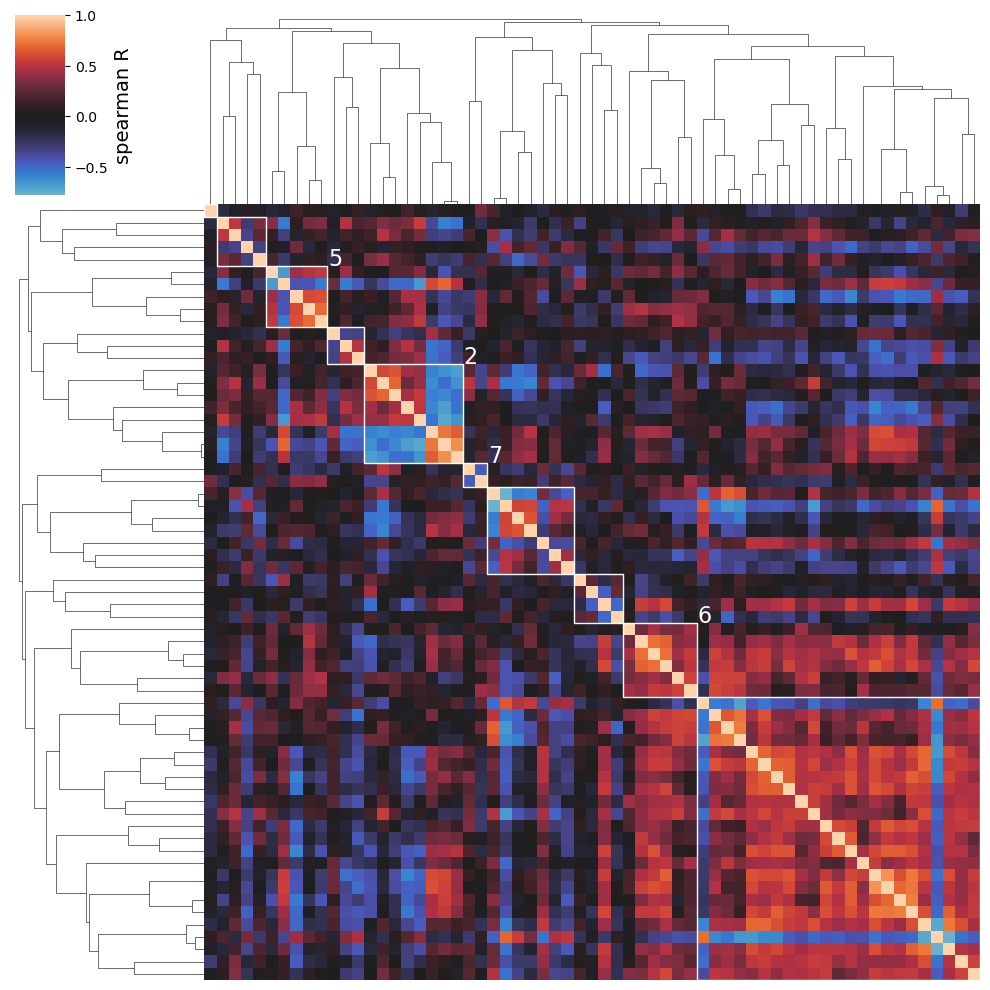

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.9, linkage='complete',
                         n_clusters=None),
 <AxesSubplot:xlabel='Control:control', ylabel='Azenta01:L-galactose'>]

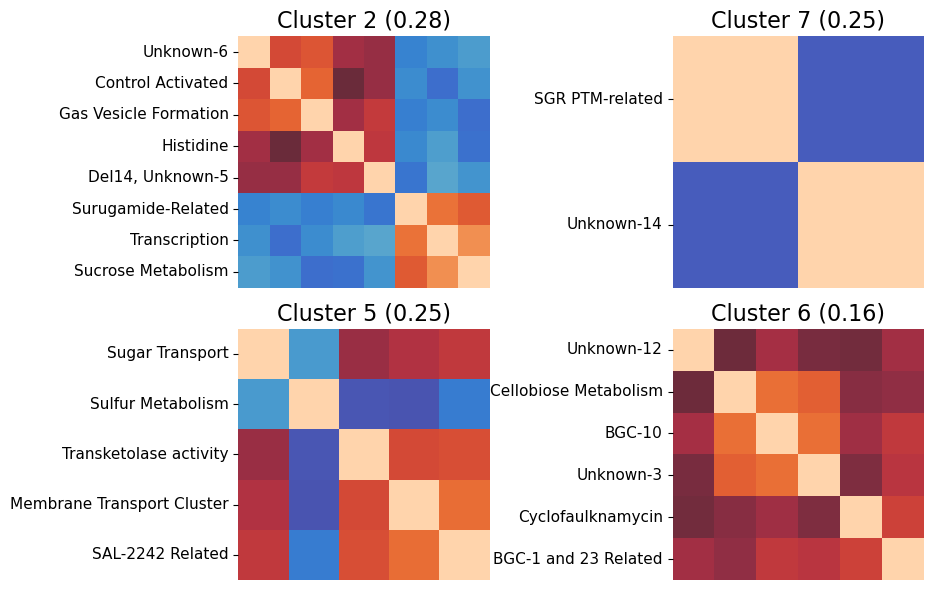

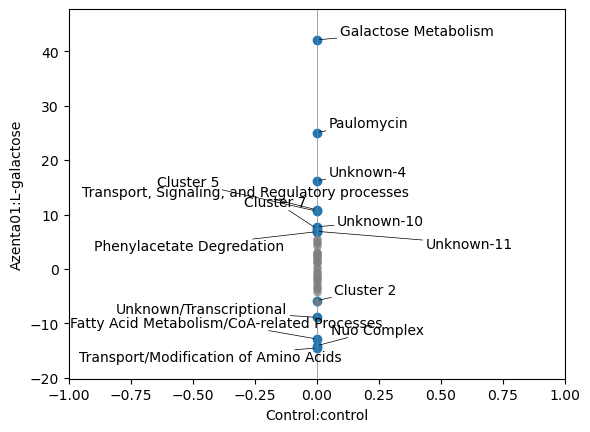

In [83]:
cluster_activities(salb_ica, show_best_clusters=True, dimca_sample1='Control:control', dimca_sample2='Azenta01:L-galactose')